模型七天的预测性能对比

ARIMA Model:
Best ARIMA model: (0, 1, 2) (1, 0, 1, 7)
ARIMA - MAE: 58.99149821965313, RMSE: 66.42647653634673, Time Taken: 25.020607948303223 seconds
LSTM Model:


/Users/0x47/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LSTM - MAE: 30.70025610204108, RMSE: 38.81551539612205, Time Taken: 33.821828842163086 seconds

Model Comparison:
ARIMA - MAE: 58.99149821965313, RMSE: 66.42647653634673, Time Taken: 25.020607948303223 seconds
LSTM - MAE: 30.70025610204108, RMSE: 38.81551539612205, Time Taken: 33.821828842163086 seconds


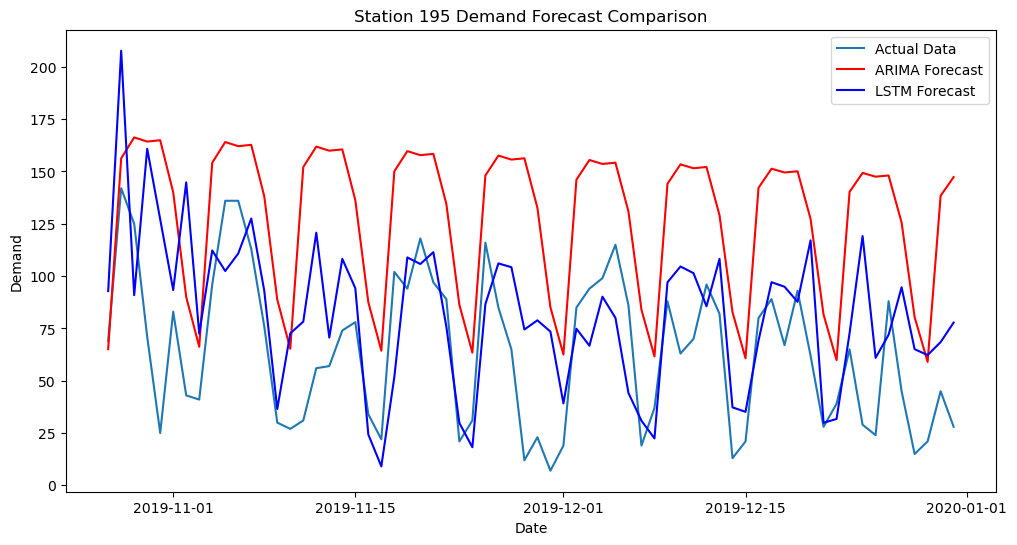

In [4]:
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data for all four quarters
quarters = ['Divvy_Trips_2019_Q1.csv', 'Divvy_Trips_2019_Q2.csv', 
            'Divvy_Trips_2019_Q3.csv', 'Divvy_Trips_2019_Q4.csv']
df_list = [pd.read_csv(file) for file in quarters]
df = pd.concat(df_list, ignore_index=True)

# Convert times to dates
df['start_time'] = pd.to_datetime(df['start_time'])
df['start_date'] = df['start_time'].dt.date

# Select data for a specific station (e.g., station ID 195)
station_id = 195
outbound_data = df[df['from_station_id'] == station_id].groupby('start_date').size()
outbound_series = outbound_data.asfreq('D', fill_value=0)

# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(outbound_series) * 0.8)
train_series, test_series = outbound_series[:train_size], outbound_series[train_size:]

# Function to evaluate accuracy
def evaluate_accuracy(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    return mae, rmse

# -------- ARIMA Model --------
print("ARIMA Model:")
start_time = time.time()
# Automatically select ARIMA model parameters
auto_arima_model = auto_arima(train_series, seasonal=True, m=7)
print("Best ARIMA model:", auto_arima_model.order, auto_arima_model.seasonal_order)

# Fit ARIMA model
arima_model = ARIMA(train_series, order=auto_arima_model.order, seasonal_order=auto_arima_model.seasonal_order)
arima_result = arima_model.fit()

# Predict on test set
arima_forecast = arima_result.forecast(steps=len(test_series))
arima_mae, arima_rmse = evaluate_accuracy(test_series, arima_forecast)
arima_time = time.time() - start_time

print(f"ARIMA - MAE: {arima_mae}, RMSE: {arima_rmse}, Time Taken: {arima_time} seconds")

# -------- LSTM Model --------
print("LSTM Model:")
scaler = MinMaxScaler(feature_range=(-1, 1))
train_series_scaled = scaler.fit_transform(train_series.values.reshape(-1, 1))
test_series_scaled = scaler.transform(test_series.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 7
X_train, y_train = create_sequences(train_series_scaled, seq_length)
X_test, y_test = create_sequences(test_series_scaled, seq_length)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Train LSTM model
lstm_model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

start_time = time.time()
epochs = 100
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        lstm_model.hidden_cell = (torch.zeros(1, 1, lstm_model.hidden_layer_size),
                                  torch.zeros(1, 1, lstm_model.hidden_layer_size))
        y_pred = lstm_model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
lstm_time = time.time() - start_time

# Forecast on test set
with torch.no_grad():
    lstm_forecast = []
    for seq in X_test:
        lstm_model.hidden_cell = (torch.zeros(1, 1, lstm_model.hidden_layer_size),
                                  torch.zeros(1, 1, lstm_model.hidden_layer_size))
        lstm_forecast.append(lstm_model(seq).item())
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1)).flatten()

# Ensure test_series and lstm_forecast have the same length
aligned_test_series = test_series[-len(lstm_forecast):]

# Calculate LSTM accuracy
lstm_mae, lstm_rmse = evaluate_accuracy(aligned_test_series, lstm_forecast)
print(f"LSTM - MAE: {lstm_mae}, RMSE: {lstm_rmse}, Time Taken: {lstm_time} seconds")

# -------- Comparison --------
print("\nModel Comparison:")
print(f"ARIMA - MAE: {arima_mae}, RMSE: {arima_rmse}, Time Taken: {arima_time} seconds")
print(f"LSTM - MAE: {lstm_mae}, RMSE: {lstm_rmse}, Time Taken: {lstm_time} seconds")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(aligned_test_series.index, aligned_test_series, label='Actual Data')
plt.plot(aligned_test_series.index, arima_forecast[:len(aligned_test_series)], label='ARIMA Forecast', color='red')
plt.plot(aligned_test_series.index, lstm_forecast, label='LSTM Forecast', color='blue')
plt.title(f'Station {station_id} Demand Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()
